In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import collections 
import time
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
np.random.seed(42)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [46]:
data_dir = "/content/drive/MyDrive/Hackathon/SmartFall_Dataset"

train = pd.read_csv('/content/drive/MyDrive/Hackathon/SmartFall_Dataset/SmartFall_Dataset/SmartFall Testing.csv')
test = pd.read_csv('/content/drive/MyDrive/Hackathon/SmartFall_Dataset/SmartFall_Dataset/SmartFall Testing.csv')

## Preprecessing

- sliding window size of 40
- if data contains all fall samples(25 samples) then, label as 'FALL'
- unless, it's all labelled as 'ADL'

In [47]:
n = 40
X_train, y_train = list(), list()

for i in tqdm(range(0, len(train)-40)):
    temp = list()
    
    temp.append(train[' ms_accelerometer_x'][i : i + n])
    temp.append(train[' ms_accelerometer_y'][i : i + n])
    temp.append(train[' ms_accelerometer_z'][i : i + n])
    
    cnt = collections.Counter(train['outcome'][i: i + n])
    num_adl = cnt[0]
    num_fall = cnt[1]
    
    if num_fall == 25:
        y_train.append(1)
    else:
        y_train.append(0)
    
    X_train.append(temp)

<ipython-input-47-1b6dcc12ad73>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(0, len(train)-40)):


  0%|          | 0/90985 [00:00<?, ?it/s]

In [48]:
n = 40
X_test_adl, X_test_fall, y_test_adl, y_test_fall = list(), list(), list(), list()
for i in tqdm(range(0, len(test) - 40)):
    temp = list()
    
    temp.append(test[' ms_accelerometer_x'][i : i + n])
    temp.append(test[' ms_accelerometer_y'][i : i + n])
    temp.append(test[' ms_accelerometer_z'][i : i + n])
    
    cnt = collections.Counter(test['outcome'][i : i + n])
    num_adl = cnt[0]
    num_fall = cnt[1]
    
    if num_fall == 25:
        y_test_fall.append(1)
        X_test_fall.append(temp)
    else:
        y_test_adl.append(0)
        X_test_adl.append(temp)

<ipython-input-48-dc245f191b2c>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(0, len(test) - 40)):


  0%|          | 0/90985 [00:00<?, ?it/s]

In [49]:
print(len(y_test_fall))
print(len(y_test_adl))

3216
87769


In [50]:
# to keep the balance between ADL and FALL data, used only part of ADL data

X_test_adl = X_test_adl[:3216]
y_test_adl = y_test_adl[:3216]

y_test = y_test_adl + y_test_fall
X_test = X_test_adl + X_test_fall

In [53]:
print('length of test data', len(X_test))

length of test data 6432


In [54]:
print('train data adl and fall ratio')
print('--------------------------------')
cnt_train = collections.Counter(y_train)
print('train data adl ratio: ', cnt_train[0])
print('train data fall ratio: ', cnt_train[1])
print('--------------------------------')

cnt_test = collections.Counter(y_test)
print('test data adl ratio: ', cnt_test[0])
print('test data fall ratio: ', cnt_test[1])

train data adl and fall ratio
--------------------------------
train data adl ratio:  87769
train data fall ratio:  3216
--------------------------------
test data adl ratio:  3216
test data fall ratio:  3216


## implementing cyclic learning rate

- implementing a simple cosine scheduler 

In [55]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

In [56]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + np.cos(np.pi*t/t_max))/2
    
    return scheduler

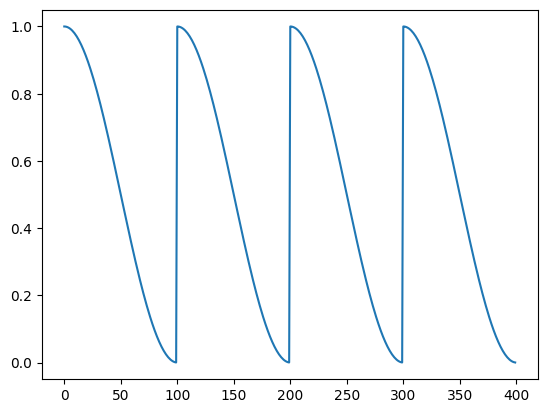

In [57]:
n = 100
sched = cosine(n)
lrs = [sched(t, 1) for t in range(n * 4)]
plt.plot(lrs)

## GRU model declaration 


In [58]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.GRU = nn.GRU(input_size = input_dim,
                          hidden_size = hidden_dim, 
                          num_layers = n_layers,
                          batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h0 = self.init_hidden(x)
        out, hn = self.GRU(x, h0)
        out = self.fc(self.relu(out[:, -1]))
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim)
        return h0.cuda()

## Preparing datasets

In [59]:
X_train = np.asarray(X_train).reshape(-1, 40, 3)
y_train = np.asarray(y_train).reshape(-1, )

X_test = np.asarray(X_test).reshape(-1, 40, 3)
y_test = np.asarray(y_test).reshape(-1, )

In [60]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

y_train = enc.fit_transform(y_train)
y_test = enc.fit_transform(y_test)

In [61]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)

In [62]:
batch_size = 1

train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
train_loader = torch.utils.data.DataLoader(
    train_data,
    shuffle=True, batch_size=batch_size)

valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))
valid_loader = torch.utils.data.DataLoader(
    valid_data,
    shuffle=True, batch_size=batch_size)

test_data =TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
test_loader = torch.utils.data.DataLoader(
    test_data,
    shuffle=True, batch_size=batch_size)

## Model training

In [63]:
input_dim = next(iter(train_loader))[0].shape[2]
output_dim = 2
n_layers = 2
hidden_dim = 256

lr = 0.0001
n_epochs = 40
iterations_per_epoch = len(train_loader)
best_acc = 0.
patience, trials = 15, 0

model = GRUNet(input_dim, hidden_dim, output_dim, n_layers).cuda()
print(model)
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
sched = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min = lr/10))
epoch_times = []

GRUNet(
  (GRU): GRU(3, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (relu): ReLU()
)


In [ ]:
train_loss, train_acc = list(), list()
print('Start model training')

for epoch in range(1, n_epochs + 1):
    start_time = time.process_time()
    for i, (X_batch, y_batch) in enumerate(train_loader):
        model.train()
        X_batch = X_batch.float().cuda()
        y_batch = y_batch.cuda()
        optimizer.zero_grad()
        out = model(X_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        sched.step()
    current_time = time.process_time()
    epoch_times.append(current_time-start_time)
    
    model.eval()
    correct, total = 0, 0
    for x_val, y_val in valid_loader:
        x_val, y_val = [t.cuda() for t in (x_val.float(), y_val)]
        out = model(x_val)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_val.size(0)
        correct += (preds == y_val).sum().item()
        
    acc = correct / total
    
    train_loss.append(loss.item())
    train_acc.append(acc)
    
    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Acc.: {acc:2.2%}')

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'SmartFall_gru.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break
print("Total Training Time: {} seconds".format(str(sum(epoch_times))))

Start model training
Epoch 1 best model saved with accuracy: 99.23%
Epoch 2 best model saved with accuracy: 99.49%
Epoch 3 best model saved with accuracy: 99.51%
Epoch 4 best model saved with accuracy: 99.55%
Epoch:   5. Loss: 0.0469. Acc.: 99.51%
Epoch 6 best model saved with accuracy: 99.60%
Epoch 8 best model saved with accuracy: 99.63%
Epoch:  10. Loss: 0.0000. Acc.: 99.64%
Epoch 10 best model saved with accuracy: 99.64%
Epoch 12 best model saved with accuracy: 99.67%
Epoch 13 best model saved with accuracy: 99.69%
Epoch:  15. Loss: 0.0000. Acc.: 99.55%
Epoch 19 best model saved with accuracy: 99.71%
Epoch:  20. Loss: 0.0000. Acc.: 99.73%
Epoch 20 best model saved with accuracy: 99.73%
Epoch 24 best model saved with accuracy: 99.74%
Epoch:  25. Loss: 0.0000. Acc.: 99.62%


In [ ]:
plt.figure(figsize=(10, 3))
plt.suptitle('GRU Model', fontsize=20, y=1.1)
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(train_loss)), train_loss)
plt.yticks([0.0, 0.1, 0.2], fontsize=15)
plt.xticks([0, 20, 40], fontsize=15)
plt.title('Loss', fontsize=20)

plt.subplot(1, 2, 2)
plt.plot(np.arange(len(train_acc)), train_acc)
plt.yticks([0.94, 0.97, 1.0], fontsize=15)
plt.xticks([0, 20, 40], fontsize=15)
plt.title('Accuracy',fontsize=20)
plt.subplots_adjust(hspace=1)

plt.show()

In [ ]:
# evaluation with test dataset
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

targets = list()
preds = list()
correct = 0
model.load_state_dict(torch.load('SmartFall_gru.pth'))
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.cuda(), y.cuda()
        output = model(X.float())
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(y.view_as(pred)).sum().item()

        targets += list(y.cpu().numpy())
        preds += list(pred.cpu().numpy())

test_acc = 100. * correct / len(test_loader.dataset)
confusion_mtx = confusion_matrix(targets, preds)
print(test_acc)
print(confusion_mtx)

In [ ]:
print(classification_report(targets, preds))

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

print(precision_score(targets, preds))
print(recall_score(targets, preds))
print(f1_score(targets, preds))

In [ ]:
input_dim = 3
output_dim = 2
n_layers = 2
hidden_dim = 256

model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)

In [ ]:
model.cuda()

In [ ]:
model.load_state_dict(torch.load('/content/SmartFall_gru.pth'))

In [ ]:
test_input = torch.Tensor([1,2,3]).repeat(40,1).unsqueeze(0)

In [ ]:
test_input.shape

In [ ]:
model(test_input.cuda())

In [ ]:
!pip install onnx

In [ ]:
torch.onnx.export(
    model,                  # PyTorch Model
    test_input.cuda(),                    # Input tensor
    'output_model.onnx',        # Output file (eg. 'output_model.onnx')
    opset_version=12,       # Operator support version
    input_names=['input'],  # Input tensor name (arbitary)
    output_names=['output'] # Output tensor name (arbitary)
)